In [9]:
import os
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiSpheresMasker
import time
import sys

# parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = params.raw_dir

study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = sub_info['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
task = 'loc'

all_data = []

for sub in subs:
    for roi in rois:
        for hemi in hemispheres:
            file_path = f'{study_dir}/{sub}/ses-01/derivatives/roi_activations/{sub}_{roi}_{hemi}_{task}_roi_activation.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                mean_activation = df['mean_activation'].mean()
                all_data.append({
                    'subject': sub,
                    'roi': roi,
                    'hemisphere': hemi,
                    'mean_activation': mean_activation
                })

results_df = pd.DataFrame(all_data)

# Calculate group averages
group_averages = results_df.groupby(['roi', 'hemisphere'])['mean_activation'].mean().reset_index()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
chart_data = []
for roi in rois:
    roi_data = {'roi': roi}
    for hemi in hemispheres:
        value = group_averages[(group_averages['roi'] == roi) & (group_averages['hemisphere'] == hemi)]['mean_activation'].values[0]
        roi_data[hemi] = value
    chart_data.append(roi_data)

print(chart_data)

[{'roi': 'pIPS', 'left': 10674.061263157893, 'right': 10216.69382982456}, {'roi': 'LO', 'left': 10772.343684210526, 'right': 10478.117524561403}]


Box plot saved as 'roi_activation_boxplot.png'


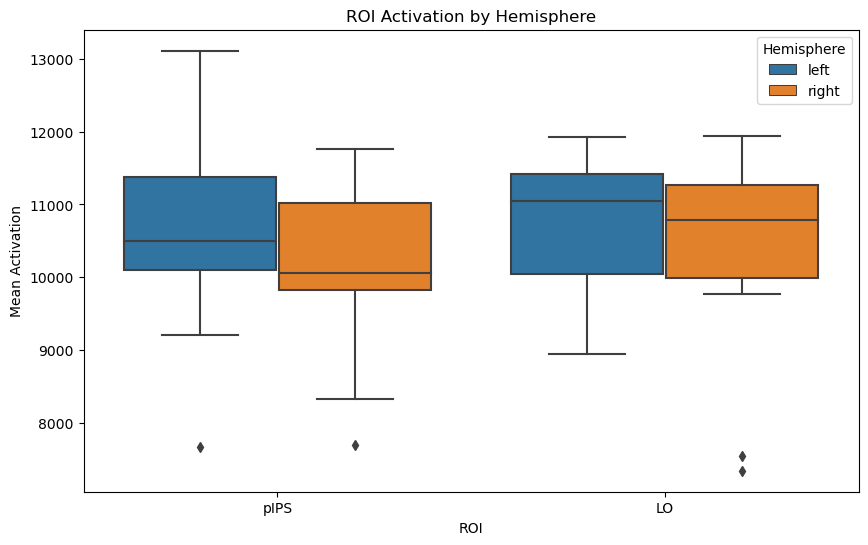

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='roi', y='mean_activation', hue='hemisphere', data=results_df)

plt.title('ROI Activation by Hemisphere')
plt.xlabel('ROI')
plt.ylabel('Mean Activation')
plt.legend(title='Hemisphere')

# Save the plot
#plt.savefig('roi_activation_boxplot.png')
#plt.close()

print("Box plot saved as 'roi_activation_boxplot.png'")

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First subplot: ROI on x-axis
sns.boxplot(x='roi', y='mean_activation', hue='hemisphere', data=results_df, ax=ax1)
ax1.set_title('ROI Activation by Hemisphere')
ax1.set_xlabel('ROI')
ax1.set_ylabel('Mean Activation')
ax1.legend(title='Hemisphere')

# Second subplot: Hemisphere on x-axis
sns.boxplot(x='hemisphere', y='mean_activation', hue='roi', data=results_df, ax=ax2)
ax2.set_title('Hemisphere Activation by ROI')
ax2.set_xlabel('Hemisphere')
ax2.set_ylabel('Mean Activation')
ax2.legend(title='ROI')

# Adjust layout and save the plot
plt.tight_layout()
#plt.savefig('roi_hemisphere_activation_boxplots.png')
#plt.close()

print("Box plots saved as 'roi_hemisphere_activation_boxplots.png'")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/hemisphere_activation_by_roi.png


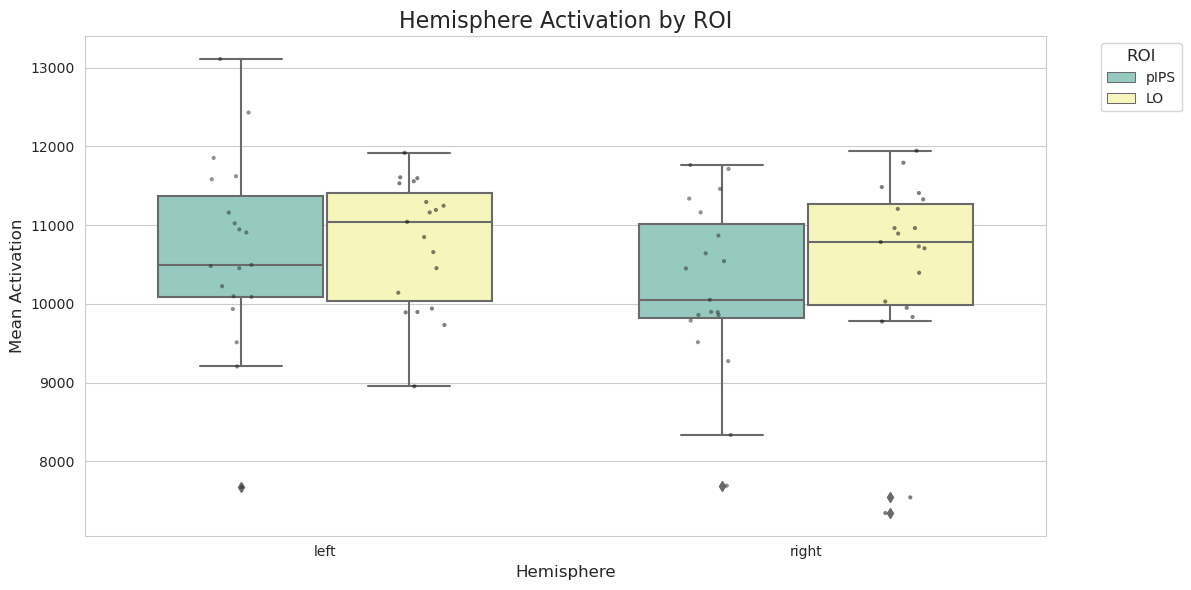

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load the data
data = results_df

# Set the color palette to match previous plots
color_palette = sns.color_palette("Set3")

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the box plot
sns.boxplot(x='hemisphere', y='mean_activation', hue='roi', 
            data=results_df, palette=color_palette[:2], width=0.7)

# Add individual data points
sns.stripplot(x='hemisphere', y='mean_activation', hue='roi', 
              data=results_df, dodge=True, alpha=0.5, 
              color='black', size=3)

# Customize the plot
plt.title('Hemisphere Activation by ROI', fontsize=16)
plt.xlabel('Hemisphere', fontsize=12)
plt.ylabel('Mean Activation', fontsize=12)

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='ROI', title_fontsize='12', fontsize='10', 
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
output_path = os.path.join(results_dir, 'hemisphere_activation_by_roi.png')
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
#plt.close()

print(f"Plot has been saved as: {output_path}")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plots have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results
Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'


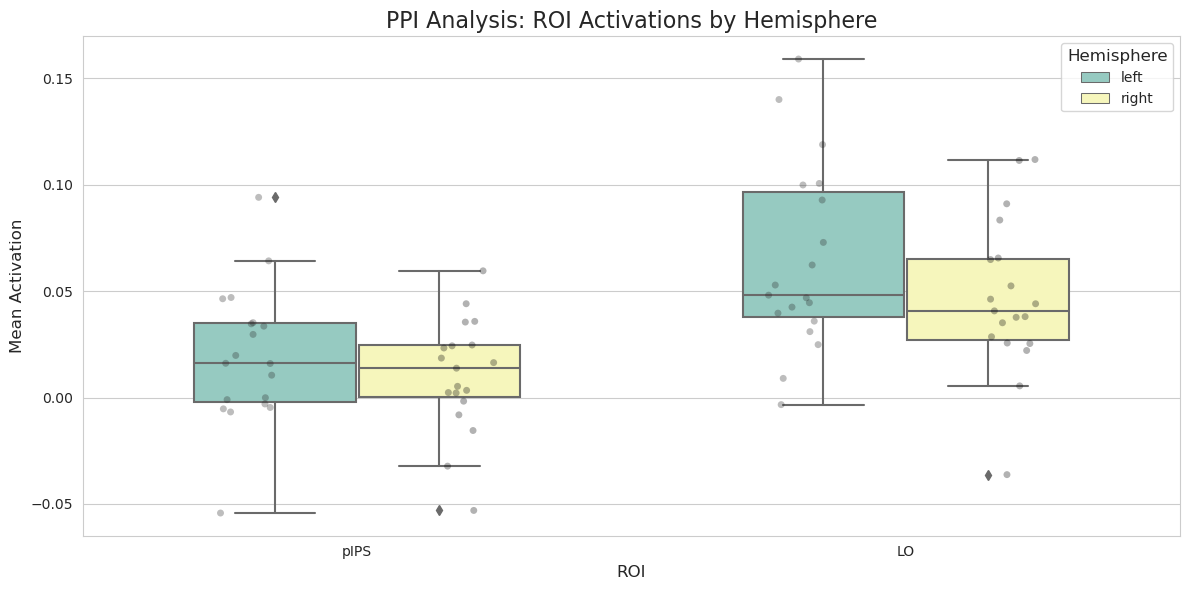

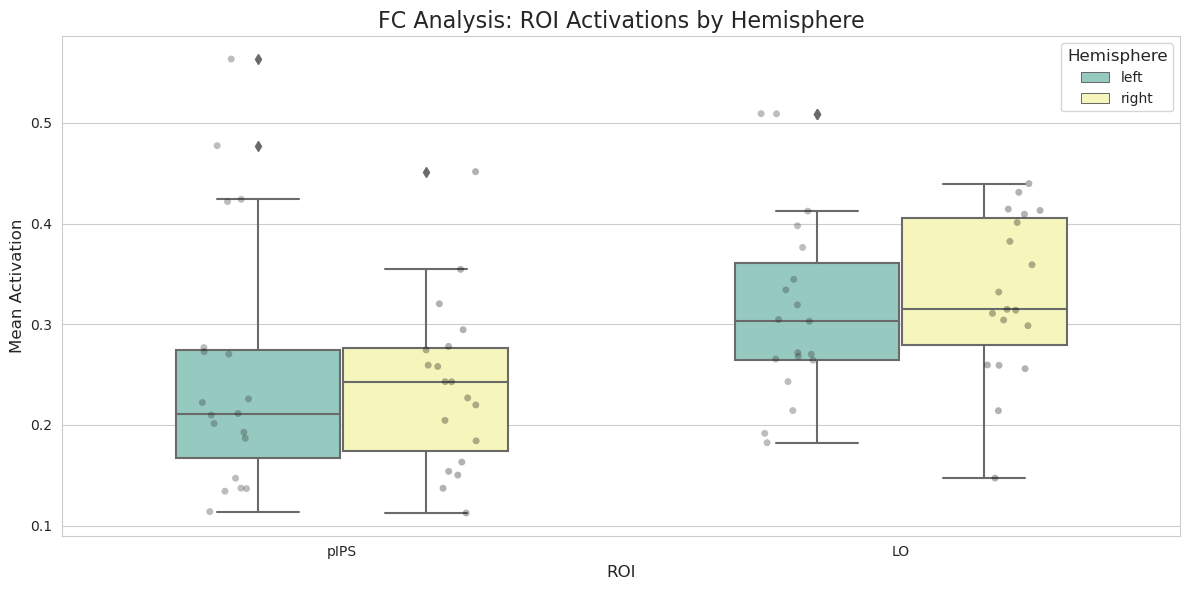

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

# Create a function to generate the plot
def create_boxplot(data, analysis_type):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Create the box plot
    sns.boxplot(x='roi', y='mean_activation', hue='hemisphere', 
                data=data[data['analysis'] == analysis_type],
                palette='Set3', width=0.6)
    
    # Customize the plot
    plt.title(f'{analysis_type.upper()} Analysis: ROI Activations by Hemisphere', fontsize=16)
    plt.xlabel('ROI', fontsize=12)
    plt.ylabel('Mean Activation', fontsize=12)
    plt.legend(title='Hemisphere', title_fontsize='12', fontsize='10')
    
    # Add individual data points
    sns.stripplot(x='roi', y='mean_activation', hue='hemisphere', 
                  data=data[data['analysis'] == analysis_type],
                  dodge=True, alpha=0.3, color='black')
    
    # Remove legend for stripplot
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Hemisphere', title_fontsize='12', fontsize='10')
    
    plt.tight_layout()
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_activations.png')
    #plt.savefig(output_path, dpi=300)
    #plt.close()

# Generate plots for both PPI and FC analyses
create_boxplot(data, 'ppi')
create_boxplot(data, 'fc')

print(f"Plots have been saved in the directory: {results_dir}")
print("Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plots have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results
Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'


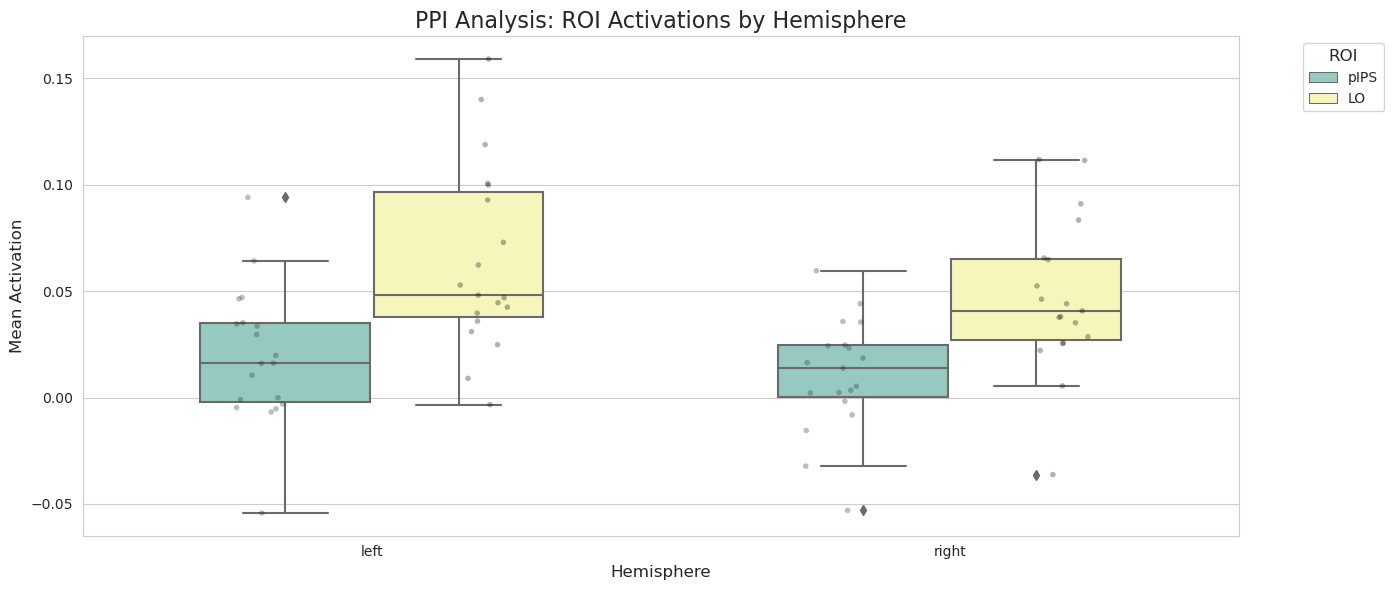

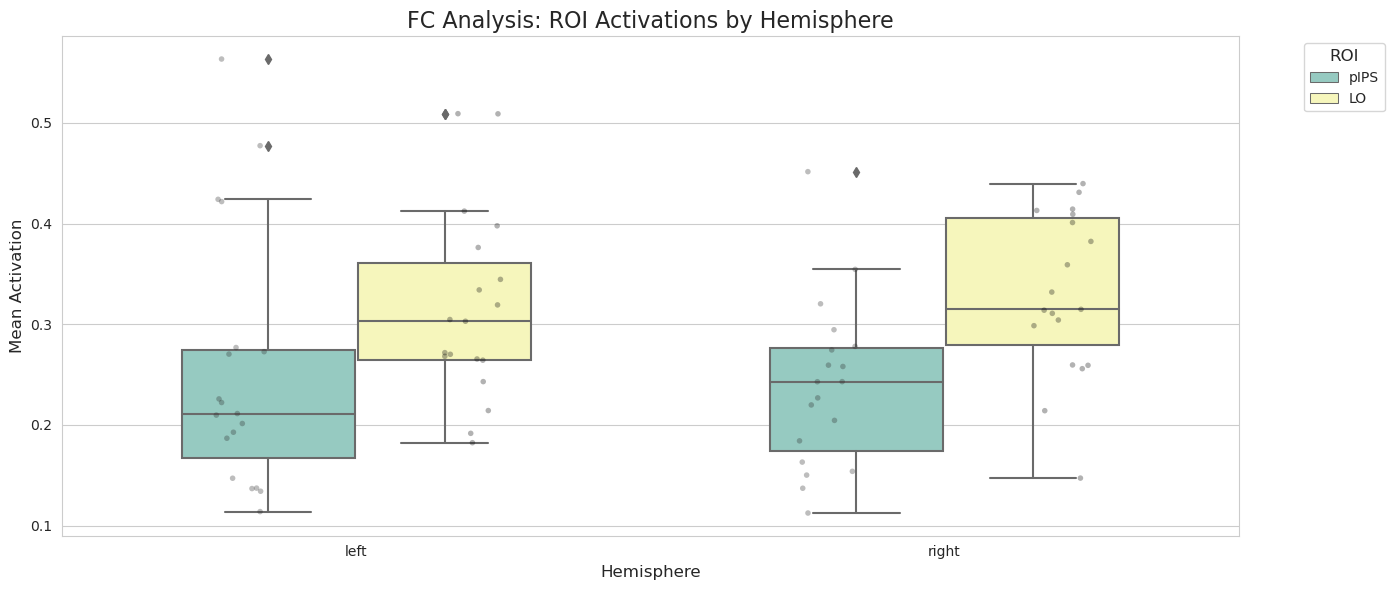

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

# Create a function to generate the plot
def create_boxplot(data, analysis_type):
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    
    # Filter data for the specific analysis
    plot_data = data[data['analysis'] == analysis_type]
    
    # Create the box plot
    sns.boxplot(x='hemisphere', y='mean_activation', hue='roi', 
                data=plot_data, palette='Set3', width=0.6)
    
    # Add individual data points
    sns.stripplot(x='hemisphere', y='mean_activation', hue='roi', 
                  data=plot_data, dodge=True, alpha=0.3, 
                  color='black', size=4)
    
    # Customize the plot
    plt.title(f'{analysis_type.upper()} Analysis: ROI Activations by Hemisphere', fontsize=16)
    plt.xlabel('Hemisphere', fontsize=12)
    plt.ylabel('Mean Activation', fontsize=12)
    
    # Adjust legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='ROI', title_fontsize='12', fontsize='10', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_activations.png')
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #plt.close()

# Generate plots for both PPI and FC analyses
create_boxplot(data, 'ppi')
create_boxplot(data, 'fc')

print(f"Plots have been saved in the directory: {results_dir}")
print("Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'")